# Modélisation du système de recommandation


<img src="./img/logo.png" alt="logo">

2 type de système de recommandation :

- **content-based** : Cette méthode n'utilise que des informations sur la description et les attributs des articles que les utilisateurs ont précédemment consommés pour modéliser les préférences de l'utilisateur. En d'autres termes, ces algorithmes tentent de recommander des articles similaires à ceux qu'un utilisateur a aimés dans le passé (ou qu'il examine dans le présent). En particulier, divers articles candidats sont comparés aux articles précédemment évalués par l'utilisateur et les articles qui correspondent le mieux sont recommandés.



- **collaboratif-filtering**: Cette méthode permet de faire des prédictions automatiques (filtrage) sur les intérêts d'un utilisateur en recueillant les préférences ou les informations sur les goûts de nombreux utilisateurs (collaboration). L'hypothèse sous-jacente de l'approche du filtrage collaboratif est que si une personne A a la même opinion qu'une personne B sur un ensemble d'éléments, A a plus de chances d'avoir l'opinion de B pour un élément donné que celle d'une personne choisie au hasard.



In [1]:
!python --version

Python 3.6.9


In [3]:
# !pip install implicit

In [4]:
from utils import DataClicks, ContentBasedRecommandation, EvaluateRS, ContentCollaboratifFiltering
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
style_plot = "seaborn-darkgrid"
plt.style.use(style_plot)

In [5]:
%%time
interaction_df, metadata_df, article_matrice_df, _ = DataClicks(
                                                        interaction_path_dir="./data/clicks/",
                                                        metadata_path="./data/articles_metadata.csv",
                                                        article_embedding_path="./data/articles_embeddings.pickle").load_data()

CPU times: user 40.8 s, sys: 33.9 s, total: 1min 14s
Wall time: 1min 23s


## Content-based model

On calcul ici la distance cosine pour connaitre les article les plus proche pour proposer les articles les plus proche d'un article déjà lu par un utilisateur

In [6]:
from scipy.spatial import distance

from random import randint

def recommandationArticle(embedding, userId, n=5):
    embedding_temp = embedding
    # on récupére tout les article lu par l'utilisateurs
    var = interaction_df.loc[interaction_df['user_id']==userId]['click_article_id']
    # on choisi un article simillaire au article lu par l'utilisateurs
    if len(var) == 0:
        # Si il n'a pas encore lu d'article on lui propose par rapport à l'article le plus populaire
        value = interaction_df.groupby("click_article_id")["click_article_id"].size().sort_values(ascending=False).index[0]
    else:
        value = randint(0, len(var))
    # On supprime les article déjà lu par l'utilisateur
    for i in range(0, len(var)):
        if i != value:
            embedding_temp = np.delete(embedding_temp, [i], 0)
    
    arr = []
    
    # on supprime l'article selectionné
    f = np.delete(embedding_temp, [value], 0)
    
    # on récupére les n articles les plus similaire à celui selectionné
    for i in range(0, n):
        # On récupére la matrice de distance
        distances = distance.cdist([embedding_temp[value]], f, "cosine")[0]
        min_index = np.argmin(distances)
        f = np.delete(f, [min_index], 0)
        result = np.where(embedding==f[min_index])
        arr.append(result[0][0])
        
    return arr



In [7]:
recommandationArticle(article_matrice_df, 0)

[165, 1421, 802, 1080, 1342]

In [10]:
%%time
model_based = ContentBasedRecommandation(path_emdedding="./data/articles_embeddings.pickle",
                                         path_user_interaction_directory="./data/clicks/")

CPU times: user 41.4 s, sys: 33.7 s, total: 1min 15s
Wall time: 1min 18s


In [11]:
model_based.recommend_(user_id=0,N=5)

[14, 1729, 53901, 796, 784]

In [20]:
import joblib
src_file_model = './data/based_model.joblib'

joblib.dump(model_based, src_file_model)

['./data/based_model.joblib']

In [4]:
import joblib
model_based = joblib.load('./data/based_model.joblib')

In [5]:
model_based.recommend_(user_id=0,N=5)

[1095, 1414, 2905, 38906, 663]

# Collaboratif Filtering model

Pour cette partie on utilisera une modélisation par factorisation de matrix (ALS, SVD...)

### Préparation du modèle / Feature engeneering


In [9]:
df = interaction_df.merge(metadata_df,left_on="click_article_id",right_on="article_id")

In [10]:
print("Il y a un total de",df[df["created_at_ts"] > df["click_timestamp"]]["article_id"].nunique(),"article qui on était mise à jour ultérieurement à une interaction.")

Il y a un total de 1052 article qui on était mise à jour ultérieurement à une interaction.


On sépare notre jeu de données en 2 partie pour la partie test et la partie entrainement.


Le jeu de données est basé sur des interaction du **01/10/2017** aux **16/10/2017**, on prend donc les 10 premiers jours pour executer l'entrainement de notre modélisation et le reste pour l'évaluation.

In [14]:
metadata_df["anciennete"] = abs(metadata_df['created_at_ts'] - pd.to_datetime("2017-10-10 00:00:00"))
metadata_df['anciennete'] = metadata_df['anciennete'] / np.timedelta64(1, 'D')
df_old = interaction_df.merge(metadata_df,left_on="click_article_id",right_on="article_id")
df_old.drop(df_old[df_old["created_at_ts"] > df_old["click_timestamp"]].index,axis=0,inplace=True)

# On reinitialise l'anciennete avec la dernière valeur que l'on gardera
metadata_df["anciennete"] = abs(metadata_df['created_at_ts'] - pd.to_datetime("2017-10-17 00:00:00"))
metadata_df['anciennete'] = metadata_df['anciennete'] / np.timedelta64(1, 'D')
df_new = interaction_df.merge(metadata_df,left_on="click_article_id",right_on="article_id")
df_new.drop(df_new[df_new["created_at_ts"] > df_new["click_timestamp"]].index,axis=0,inplace=True)

In [15]:
old_interaction = df_old[df_old["click_timestamp"] <= pd.to_datetime("2017-10-10 00:00:00")].copy()
new_interaction = df_new[df_new["click_timestamp"] <= pd.to_datetime("2017-10-17 00:00:00")].copy()
print("Nombre d\'interaction les 10 premiers jours :",len(old_interaction))
print("Nombre d\'interaction du 01/10 aux 16/10 inclue :",len(new_interaction))

Nombre d'interaction les 10 premiers jours : 1764959
Nombre d'interaction du 01/10 aux 16/10 inclue : 2964290


In [16]:
old_interaction.head()

,user_id,session_id,session_start,session_size,click_article_id,click_timestamp,click_environment,click_deviceGroup,click_os,click_country,click_region,click_referrer_type,article_id,category_id,created_at_ts,publisher_id,words_count,anciennete
0,0,1506825423271737,2017-10-01 02:37:03,2,157541,2017-10-01 03:00:28.020,4,3,20,1,20,2,157541,281,2017-09-30 19:41:58,0,280,9.17919
1,20,1506825727279757,2017-10-01 02:42:07,2,157541,2017-10-01 05:42:28.634,4,1,17,1,9,1,157541,281,2017-09-30 19:41:58,0,280,9.17919
2,44,1506826139185781,2017-10-01 02:48:59,5,157541,2017-10-01 11:27:58.141,4,1,17,1,12,1,157541,281,2017-09-30 19:41:58,0,280,9.17919
3,45,1506826142324782,2017-10-01 02:49:02,2,157541,2017-10-01 03:08:29.970,4,1,17,1,17,1,157541,281,2017-09-30 19:41:58,0,280,9.17919
4,76,1506826463226813,2017-10-01 02:54:23,2,157541,2017-10-01 03:33:43.469,4,3,2,1,21,1,157541,281,2017-09-30 19:41:58,0,280,9.17919


In [17]:
rating = old_interaction[['click_article_id', 'user_id']].groupby(["click_article_id"],as_index=False).agg("count")
rating.rename(columns={"user_id":"interaction"},inplace=True)
rating.rename(columns={"click_article_id":"click_article_id_inter"},inplace=True)
rating.head()

,click_article_id_inter,interaction
0,3,1
1,27,1
2,81,2
3,84,1
4,115,1


In [18]:
final_df_train = old_interaction.merge(rating,how="left",left_on=["article_id"],right_on=["click_article_id_inter"])
# on retire les columns inutile
final_df_train.drop(["session_id","click_article_id","session_start","session_size","click_environment",
                     "click_deviceGroup","click_os","click_country","click_region",
                     "click_referrer_type","click_article_id_inter","publisher_id"],axis=1,inplace=True)
# on remplace les NA par des 0 pour les futurs traitement
final_df_train["interaction"] = final_df_train["interaction"].fillna(0)

In [19]:
final_df_train.head()

,user_id,click_timestamp,article_id,category_id,created_at_ts,words_count,anciennete,interaction
0,0,2017-10-01 03:00:28.020,157541,281,2017-09-30 19:41:58,280,9.17919,365
1,20,2017-10-01 05:42:28.634,157541,281,2017-09-30 19:41:58,280,9.17919,365
2,44,2017-10-01 11:27:58.141,157541,281,2017-09-30 19:41:58,280,9.17919,365
3,45,2017-10-01 03:08:29.970,157541,281,2017-09-30 19:41:58,280,9.17919,365
4,76,2017-10-01 03:33:43.469,157541,281,2017-09-30 19:41:58,280,9.17919,365


### Sauvegarde du jeu de données 

In [16]:
final_df_train.to_csv("./data/final_df_train.csv")

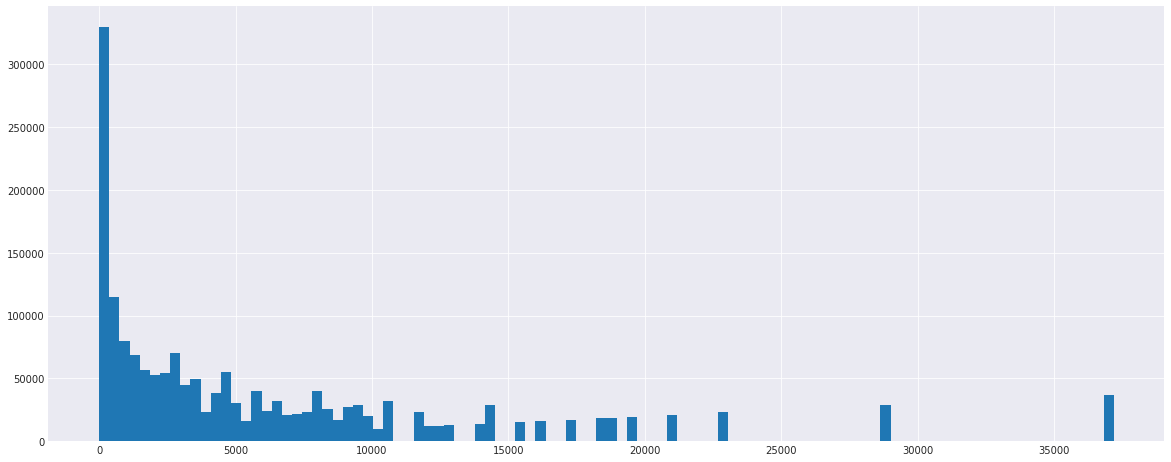

In [17]:
plt.figure(figsize=(20,8))
final_df_train["interaction"].hist(bins=100)
plt.show()

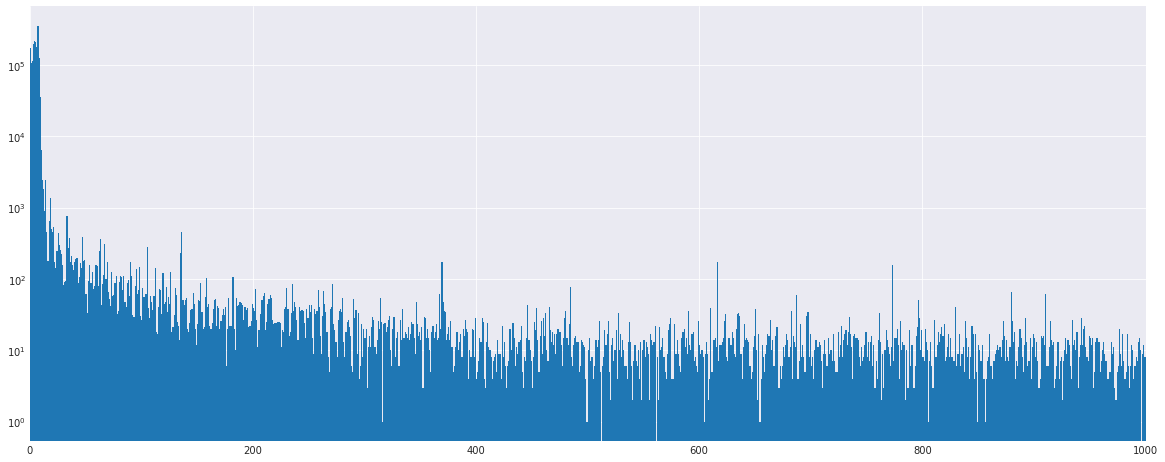

In [18]:
plt.figure(figsize=(20,8))
plt.xlim((0,1000))
max_bins = int(final_df_train["anciennete"].max() + final_df_train["anciennete"].min())
final_df_train["anciennete"].hist(bins=max_bins)
plt.yscale("log")
plt.show()

On vois sur ce graphique que les articles sont généralement lu dans les jours qui suivent leur publication.

In [19]:
df_interact_cat = final_df_train.groupby(["user_id","category_id"]).size().to_frame().reset_index().rename(columns={0:"interaction_cat"})

In [20]:
print("Dimensionnalité : ",df_interact_cat.shape)
df_interact_cat.head()

Dimensionnalité :  (1184450, 3)


,user_id,category_id,interaction_cat
0,0,136,1
1,0,186,2
2,0,209,1
3,0,281,2
4,0,375,1


In [21]:
df_interact_article = final_df_train.groupby(["user_id","article_id"]).size().to_frame().reset_index().rename(columns={0:"interaction_article"})

In [22]:
print("Dimensionnalité : ",df_interact_article.shape)
df_interact_article.head()

Dimensionnalité :  (1741394, 3)


,user_id,article_id,interaction_article
0,0,68866,1
1,0,87205,1
2,0,87224,1
3,0,96755,1
4,0,157541,1


## Modélisaiton

In [23]:
import scipy.sparse as sparse
import implicit

In [63]:
sparse_user_item = sparse.csr_matrix((df_interact_article['interaction_article'].astype(float),
                                     (df_interact_article['user_id'], df_interact_article['article_id'])))

In [64]:
model = implicit.als.AlternatingLeastSquares(factors=100,iterations=200,regularization=0.1)

In [65]:
model.fit(sparse_user_item*1)

  0%|          | 0/200 [00:00<?, ?it/s]

In [27]:
userid = 10
recommendations = model.recommend(userid, sparse_user_item[userid],N=5)

In [28]:
print("Voici la liste des article recommandé :",recommendations[0].tolist())

Voici la liste des article recommandé : [206934, 70646, 338350, 285342, 202493]


In [45]:
model_cf = ContentCollaboratifFiltering("./data/final_df_train.csv")

In [30]:
model_cf.train_(factors=100,iterations=200,regularization=0.1,alpha=10)

  0%|          | 0/200 [00:00<?, ?it/s]

In [31]:
model_cf.recommend_(userid)

[168623, 235230, 206934, 205846, 209294]

In [35]:
import itertools as it

evaluate_recommendation_system = EvaluateRS(path_user_interaction_directory="./data/clicks/",
                                            metadata_path="./data/articles_metadata.csv")

def find_tuning(model,params : dict,list_user : list):
    all_keys = sorted(params)
    combinations = list(it.product(*(params[k] for k in all_keys)))
    test_comb = 0
    best_score = 0
    best_params = {}
    nb_comb = len(combinations)
    for param in combinations:
        if 'factors' in all_keys:
            factors = param[all_keys.index('factors')]
        else:
            factors = 100
        
        if 'iterations' in all_keys:
            iterations = param[all_keys.index('iterations')]
        else:
            iterations = 200
        
        if 'regularization' in all_keys:
            regularization = param[all_keys.index('regularization')]
        else:
            regularization = 0.1
        
        if 'alpha' in all_keys:
            alpha = param[all_keys.index('alpha')]
        else: 
            alpha = 1
        
        model.train_(factors=factors,iterations=iterations,regularization=regularization,alpha=alpha,show_progress=False)
        map_test = model.recommend_list_user_(list_user)
        evaluate_recommendation_system.evaluate_(map_test,list_user)
        
        score = evaluate_recommendation_system.count_cat
        
        if score > best_score:
            best_score = score
            best_params = params = {
                "factors":factors,
                "iterations":iterations,
                "regularization":regularization,
                "alpha":alpha
            }
        if test_comb % (nb_comb//10) == 0:
            print(round((test_comb/nb_comb)*100),"%")
        test_comb+=1
    return best_score, best_params

In [36]:
params = {
    "factors":[15,50,100,200],
    "iterations":[20,50,100,200,400],
    "regularization":[0.001,0.01,0.1,1],
    "alpha":[1,5,10,20,40]
}

size_sample = 100
list_user = [i for i in range(size_sample)]

In [37]:
best_score, best_params = find_tuning(model_cf,params,list_user)

0 %
10 %
20 %
30 %
40 %
50 %
60 %
70 %
80 %
90 %


In [38]:
print("Le nombre maximal de catégorie simmilaire identifier est de :", best_score)
print("Les meilleurs paramètres sont :", best_params)

Le nombre maximal de catégorie simmilaire identifier est de : 637
Les meilleurs paramètres sont : {'factors': 200, 'iterations': 100, 'regularization': 0.01, 'alpha': 10}


In [19]:
best_params = {'factors': 200, 'iterations': 100, 'regularization': 0.01, 'alpha': 10}

## Evaluation

Pour l'évaluation on regardera plusieur métriques, notamment si les catégorie entre les article recommandé et réellement lu sont simillaire ainsi que l'ancienneté des articles recommandés (on regardera également si des article recommandé on était lu par l'utilisateur).

In [77]:
size_sample = 1000
list_user_test = [i for i in range(size_sample)]

In [78]:
%%time
map_test_cf = model_cf.recommend_list_user_(list_user_test)

CPU times: user 966 ms, sys: 81.2 ms, total: 1.05 s
Wall time: 1.3 s


In [35]:
# %%time
# map_test_based = model_based.recommend_list_user_(list_user_test)

CPU times: user 49min 20s, sys: 18min 56s, total: 1h 8min 17s
Wall time: 1h 8min 28s


In [62]:
# import pickle
# src_file = './data/map_test_based.pickle'
# with open(src_file, 'wb') as f:
#     pickle.dump(map_test_based, f)

In [34]:
import pickle
src_file = './data/map_test_based.pickle'

map_test_file = open(src_file,"rb")
map_test_based = pickle.load(map_test_file)
map_test_file.close()

In [79]:
%%time
evaluate_recommendation_system = EvaluateRS(path_user_interaction_directory="./data/clicks/",
                                            metadata_path="./data/articles_metadata.csv")

CPU times: user 55.7 s, sys: 31.6 s, total: 1min 27s
Wall time: 1min 29s


In [80]:
evaluate_recommendation_system.evaluate_(map_test_cf,list_user_test)
evaluate_recommendation_system.display_result()

L'ancienneté des articles proposés sont d'environ 14.079 jours.
Il y a un total de 3771 catégories simillaire soit 36.298%.
Et le nombre d'article recommandé qui à était vraiment lu est de 6 


In [37]:
evaluate_recommendation_system.evaluate_(map_test_based,list_user_test)
evaluate_recommendation_system.display_result()

L'ancienneté des articles proposés sont d'environ 462.447 jours.
Il y a un total de 18 catégories simillaire soit 0.173%.
Et le nombre d'article recommandé qui à était vraiment lu est de 0 


# Echantillion prédiction pour alleger l'azure function


> On entraine notre modélisation final sur l'ensemble du jeu de données

In [11]:
df = interaction_df.merge(metadata_df,left_on="click_article_id",right_on="article_id")

In [12]:
# On reinitialise l'anciennete avec la dernière valeur que l'on gardera
metadata_df["anciennete"] = abs(metadata_df['created_at_ts'] - pd.to_datetime("2017-10-17 00:00:00"))
metadata_df['anciennete'] = metadata_df['anciennete'] / np.timedelta64(1, 'D')
df_new = interaction_df.merge(metadata_df,left_on="click_article_id",right_on="article_id")
df_new.drop(df_new[df_new["created_at_ts"] > df_new["click_timestamp"]].index,axis=0,inplace=True)

In [14]:
new_interaction = df_new[df_new["click_timestamp"] <= pd.to_datetime("2017-10-17 00:00:00")].copy()

In [15]:
rating = new_interaction[['click_article_id', 'user_id']].groupby(["click_article_id"],as_index=False).agg("count")
rating.rename(columns={"user_id":"interaction"},inplace=True)
rating.rename(columns={"click_article_id":"click_article_id_inter"},inplace=True)
rating.head()

final_df = new_interaction.merge(rating,how="left",left_on=["article_id"],right_on=["click_article_id_inter"])
# on retire les columns inutile
final_df.drop(["session_id","click_article_id","session_start","session_size","click_environment",
                     "click_deviceGroup","click_os","click_country","click_region",
                     "click_referrer_type","click_article_id_inter","publisher_id"],axis=1,inplace=True)
# on remplace les NA par des 0 pour les futurs traitement
final_df["interaction"] = final_df["interaction"].fillna(0)

## Sauvegarde du jeu de données final

In [24]:
final_df.to_csv("./data/final_df.csv")

## Entrainement et recommandation

In [25]:
%%time
model_cf = ContentCollaboratifFiltering("./data/final_df.csv")

CPU times: user 3.1 s, sys: 281 ms, total: 3.38 s
Wall time: 4.73 s


In [26]:
%%time
model_cf.train_(factors=best_params["factors"],
                iterations=best_params["iterations"],
                regularization=best_params["regularization"],
                alpha=best_params["alpha"],show_progress=False)

CPU times: user 17.9 s, sys: 0 ns, total: 17.9 s
Wall time: 18 s


In [27]:
size_sample = 10000
list_user = [i for i in range(size_sample)]

In [28]:
%%time
map_cf = model_cf.recommend_list_user_(list_user)

CPU times: user 8.85 s, sys: 1.48 s, total: 10.3 s
Wall time: 12.8 s


In [29]:
import pickle
src_file = './data/recommandation_cf.pickle'
with open(src_file, 'wb') as f:
    pickle.dump(map_cf, f)